In [2]:
import os
import time
import json
import utils
import parse
import fasttext
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt



In [12]:
columns = ["suitable"] + [f"run_{i}" for i in range(15)]
df = pd.read_csv("backup_25.csv")#.loc[:, columns]
y_true, y_pred = [], []

for i in range(15):
    y_true.extend(df.suitable.values.tolist())
    y_pred.extend(df[f"run_{i}"].values.tolist())


microF1=0.9163
macroF1=0.7159


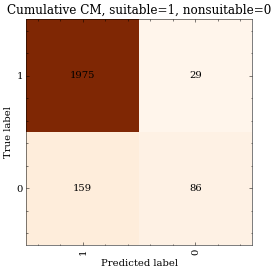

(0.9162962962962963, 0.7159204969199487)

In [7]:
utils.plot_cm(y_true, y_pred, labels=[1,0], title="Cumulative CM, suitable=1, nonsuitable=0", 
save="images/25_cumulative_CM.png", include_metrics=False, figsize=(4,4))

In [8]:
f1s = list()
for i in range(15):
    from sklearn.metrics import f1_score
    from sklearn.dummy import DummyClassifier
    y_true = df.suitable.values
    y_pred = df[f"run_{i}"].values
    f1s.append(f1_score(y_true, y_pred))

In [9]:
np.mean(f1s), np.std(f1s)

(0.9544980538407455, 0.002851664406272193)

In [10]:
dummy_f1s = list()
for i in range(15):
    from sklearn.metrics import f1_score
    from sklearn.dummy import DummyClassifier
    y_true = df.suitable.values
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(y_true, y_true)
    y_pred = dummy_clf.predict(y_true)
    dummy_f1s.append(f1_score(y_true, y_pred))
print(f"Dummy clf: strategy: 'stratified', {np.mean(dummy_f1s):0.3} +/- {np.std(dummy_f1s):0.3}")
p = stats.mannwhitneyu(f1s, dummy_f1s, alternative='greater')[1]
print(f"\t p_value: {p:0.3}")
dummy_f1s = list()
for i in range(15):
    from sklearn.metrics import f1_score
    from sklearn.dummy import DummyClassifier
    y_true = df.suitable.values
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(y_true, y_true)
    y_pred = dummy_clf.predict(y_true)
    dummy_f1s.append(f1_score(y_true, y_pred))
print(f"Dummy clf: strategy: 'most_frequent', {np.mean(dummy_f1s):0.3} +/- {np.std(dummy_f1s):0.3}")
p = stats.mannwhitneyu(f1s, dummy_f1s, alternative='greater')[1]
print(f"\t p_value: {p:0.3}")

Dummy clf: strategy: 'stratified', 0.893 +/- 0.0114
	 p_value: 1.68e-06
Dummy clf: strategy: 'most_frequent', 0.942 +/- 0.0
	 p_value: 3.41e-07


# Which categories get misclassified?

In [25]:
results = list()
run = 0
for run in range(15):
    misclassified = df.suitable != df[f"run_{run}"]
    for i in df[misclassified].index:
        y_true = df.loc[i, "suitable"]
        y_pred = df.loc[i, f"run_{run}"]
        primary = df.loc[i, "primary"]

        results.append({
            "primary": primary,
            "y_true": y_true,
            "y_pred": y_pred
        })


In [31]:
print(pd.DataFrame(data=results).groupby("primary").count().sort_values("y_true", ascending=False)["y_true"].to_markdown())

| primary                    |   y_true |
|:---------------------------|---------:|
| Non-textual                |      125 |
| Not Slovene                |      116 |
| Machine Translation        |       76 |
| Too Short/Incoherent       |       63 |
| Too Long                   |       51 |
| HTML Source Code           |       30 |
| Forum                      |       23 |
| Promotion of a Product     |       17 |
| List of Summaries/Excerpts |       16 |
| Generated Text             |       15 |
| Instruction                |       14 |
| Information/Explanation    |        6 |
| News/Reporting             |        4 |
| Announcement               |        4 |
| Legal/Regulation           |        2 |
| Opinion/Argumentation      |        2 |
| Encoding Issues            |        1 |


In [42]:
df2 = pd.DataFrame(data=results).groupby("primary").count().sort_values("y_true", ascending=False)
df2["misclassified_counts"] = df2.y_true
df2.drop(columns=["y_true", "y_pred"], inplace=True)

df2["counts_in_test_split"] = [15*sum(df.primary == c) for c in df2.index]
df2["misclassification_ratio"] = df2.misclassified_counts / df2.counts_in_test_split

df2.sort_values("misclassification_ratio", ascending=False, inplace=True)
df2

,misclassified_counts,counts_in_test_split,misclassification_ratio
primary,,,
HTML Source Code,30,30,1.000000
Generated Text,15,15,1.000000
Too Long,51,60,0.850000
Not Slovene,116,165,0.703030
Too Short/Incoherent,63,90,0.700000
Non-textual,125,180,0.694444
Machine Translation,76,135,0.562963
Instruction,14,150,0.093333
Forum,23,375,0.061333


In [43]:
print(df2.to_markdown())

| primary                    |   misclassified_counts |   counts_in_test_split |   misclassification_ratio |
|:---------------------------|-----------------------:|-----------------------:|--------------------------:|
| HTML Source Code           |                     30 |                     30 |                1          |
| Generated Text             |                     15 |                     15 |                1          |
| Too Long                   |                     51 |                     60 |                0.85       |
| Not Slovene                |                    116 |                    165 |                0.70303    |
| Too Short/Incoherent       |                     63 |                     90 |                0.7        |
| Non-textual                |                    125 |                    180 |                0.694444   |
| Machine Translation        |                     76 |                    135 |                0.562963   |
| Instruction      